### Confirm weights of (frozen) trained model match weights of original DINOv2

In [1]:
import torch

# DINOv2 original backbone
dinov2_hub = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14')

Using cache found in /home/zsuri/.cache/torch/hub/facebookresearch_dinov2_main
/home/zsuri/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/zsuri/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/zsuri/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


Extract backbone weights from the entire model weights

In [2]:
loaded = torch.load("work_dirs/dinov2_vitb14_cityscapes_ms_config/epoch_120.pth")

cleaned_state_dict = {"state_dict": {k.replace("backbone.", ""):v for k,v in loaded['state_dict'].items() if k.startswith("backbone")}}

torch.save(cleaned_state_dict, "work_dirs/dinov2_vitb14_cityscapes_ms_config/cleaned_epoch_120.pth")


In [3]:
from models.backbones import DinoVisionBackbone

# our mmseg compatible dinov2 backbone
dino = DinoVisionBackbone("base",img_size=(518,518),
        patch_size=14, pretrained="work_dirs/dinov2_vitb14_cityscapes_ms_config/cleaned_epoch_120.pth")

/home/zsuri/networks/home/projects/dinov2_mmsegmentation/models/backbones/vit_dinov2.py:68: UserWarning: DeprecationWarning: pretrained is deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is deprecated, '


02/20 10:40:27 - mmengine - INFO - load model from: work_dirs/dinov2_vitb14_cityscapes_ms_config/cleaned_epoch_120.pth
02/20 10:40:27 - mmengine - INFO - Loads checkpoint by local backend from path: work_dirs/dinov2_vitb14_cityscapes_ms_config/cleaned_epoch_120.pth
02/20 10:40:31 - mmengine - INFO - 
cls_token - torch.Size([1, 1, 768]): 
PretrainedInit: load from work_dirs/dinov2_vitb14_cityscapes_ms_config/cleaned_epoch_120.pth 
 
02/20 10:40:31 - mmengine - INFO - 
pos_embed - torch.Size([1, 1370, 768]): 
PretrainedInit: load from work_dirs/dinov2_vitb14_cityscapes_ms_config/cleaned_epoch_120.pth 
 
02/20 10:40:31 - mmengine - INFO - 
mask_token - torch.Size([1, 768]): 
The value is the same before and after calling `init_weights` of DinoVisionBackbone  
 
02/20 10:40:31 - mmengine - INFO - 
patch_embed.proj.weight - torch.Size([768, 3, 14, 14]): 
PretrainedInit: load from work_dirs/dinov2_vitb14_cityscapes_ms_config/cleaned_epoch_120.pth 
 
02/20 10:40:31 - mmengine - INFO - 
patch_

In [4]:
# Compare both
for (name, backbone_param), (_, hub_param) in zip(dino.named_parameters(), dinov2_hub.named_parameters()):
    if not torch.allclose(backbone_param, hub_param):
        print(f"Tensor mismatch: {name}")


___
## Inference Demo

In [13]:
from mmseg.apis import init_model, inference_model, show_result_pyplot
from models.backbones import DinoVisionBackbone
from dinov2.eval.segmentation.models.decode_heads.linear_head import BNHead

# initialize model without checkpoint
model = init_model("configs/dinov2_vitb14_cityscapes_ms_config.py", "work_dirs/dinov2_vitb14_cityscapes_ms_config/epoch_140.pth")

02/20 11:04:46 - mmengine - INFO - 
cls_token - torch.Size([1, 1, 768]): 
The value is the same before and after calling `init_weights` of DinoVisionBackbone  
 
02/20 11:04:46 - mmengine - INFO - 
pos_embed - torch.Size([1, 1370, 768]): 
The value is the same before and after calling `init_weights` of DinoVisionBackbone  
 
02/20 11:04:46 - mmengine - INFO - 
mask_token - torch.Size([1, 768]): 
The value is the same before and after calling `init_weights` of DinoVisionBackbone  
 
02/20 11:04:46 - mmengine - INFO - 
patch_embed.proj.weight - torch.Size([768, 3, 14, 14]): 
The value is the same before and after calling `init_weights` of DinoVisionBackbone  
 
02/20 11:04:46 - mmengine - INFO - 
patch_embed.proj.bias - torch.Size([768]): 
The value is the same before and after calling `init_weights` of DinoVisionBackbone  
 
02/20 11:04:46 - mmengine - INFO - 
blocks.0.norm1.weight - torch.Size([768]): 
The value is the same before and after calling `init_weights` of DinoVisionBackbone 

/home/zsuri/networks/home/projects/lib/mmsegmentation/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/home/zsuri/networks/home/projects/lib/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:250: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


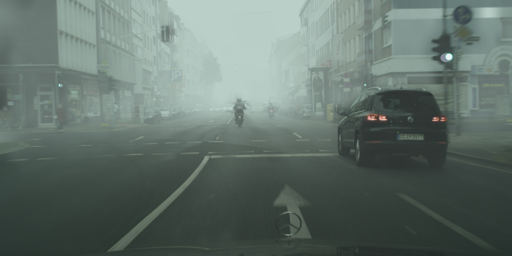

In [14]:
import urllib
from PIL import Image
import numpy as np


def load_image_from_url(url: str) -> Image:
    with urllib.request.urlopen(url) as f:
        return Image.open(f).convert("RGB")


EXAMPLE_IMAGE_URL = "https://people.ee.ethz.ch/~csakarid/SFSU_synthetic/images/Foggy_Cityscapes/dusseldorf_000081_000019_leftImg8bit_foggy_beta_0.02.png"


image = load_image_from_url(EXAMPLE_IMAGE_URL)
np_image = np.array(image)[:, :, ::-1]
display(image)

In [15]:
result = inference_model(model, np_image)

vis_image = show_result_pyplot(model, np_image, result)

/home/zsuri/miniconda3/envs/dinov2/lib/python3.9/site-packages/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


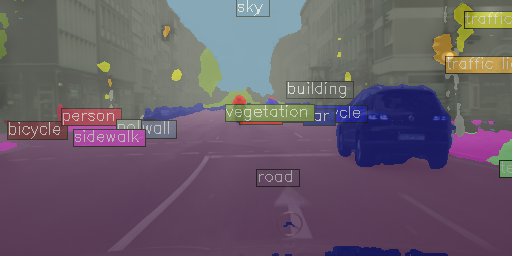

In [18]:
display(Image.fromarray(vis_image.astype('uint8'), 'RGB'))